## MNIST DCGAN

Nous allons créer un GAN qui génère des chiffres manuscrits synthétiques.

Code utilisé et modifié depuis:
- https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_dcgan.py

### Importing libraries
### Importer les bibliothèques

In [44]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input,Reshape, Dense, Dropout, Flatten,Conv2D, UpSampling2D,LeakyReLU
from tensorflow.keras.models import Model, Sequential
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras import initializers


K.set_image_dim_ordering('th')

### We are going to use the Adam optimizer for training
### Nous allons utiliser l'optimiseur Adam pour l'apprentissage

In [45]:
# Use Adam as the Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

## Load the data
## Charger les données

Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28) (10000,)


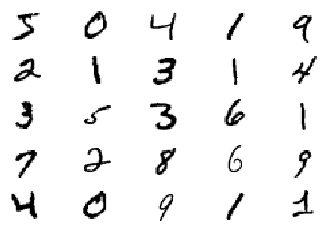

In [46]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#convert from unsigned ints to floats
X_train = X_train.astype('float32')
#scale from [0,255] to [0,1]
X_train= X_train / 255.0
#X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_train=np.expand_dims(X_train, axis=-1)
# summarize the shape of the dataset
print('Train', X_train.shape, y_train.shape)
print('Test' , X_test.shape, y_test.shape)

# plot the first 25 raw pixel data
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis( 'off' )
    # plot raw pixel data
    plt.imshow(X_train[i].reshape(28,28),cmap= 'gray_r')
plt.show()

## Define the discriminator
## Définir le discriminateur

In [43]:
def def_discriminator(in_shape=(28,28,1)):
    # Make our Discriminator Model
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                             input_shape=in_shape, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    #print(discriminator.summary())
    discriminator.compile(loss='binary_crossentropy', optimizer=adam)
    return discriminator

discriminator=def_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

## Define the generator
## Définir le générateur

In [54]:
def def_generator():
    # Make our Generator Model
    generator = Sequential()

    # Transforms the input into a 7 × 7 128-channel feature map
    generator.add(Dense(128*7*7, input_dim=latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape(( 7, 7,128)))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2, 2)))
    # Produces a 28 × 28 1-channel feature map (shape of a MNIST image)
    generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
    #print(generator.summary())
    generator.compile(loss='binary_crossentropy', optimizer=adam)
    return generator

generator=def_generator()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 28, 28, 64)       

## Build the GAN
## Construisez le GAN

In [55]:
# The dimensionality has been set at 100 for consistency with other GAN implementations. 
# But 10 works better here
latent_dim = 100


# Creating the Adversarial Network. We need to make the Discriminator weights
# non trainable. This only applies to the GAN model.
discriminator.trainable = False
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

# Our Discriminator and Generator Losses
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i].reshape(28,28), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

#Save the generator and discriminator networks (and weights) for later use
#def saveModels(epoch):
    #generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    #discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)

## Train our GAN and Plot the Synthetic Image Outputs 
## Former notre GAN et afficher les images synthétiques

After each consecutive Epoch we can see how synthetic images being improved 

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 5
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


100%|██████████| 468/468 [08:17<00:00,  1.06s/it]


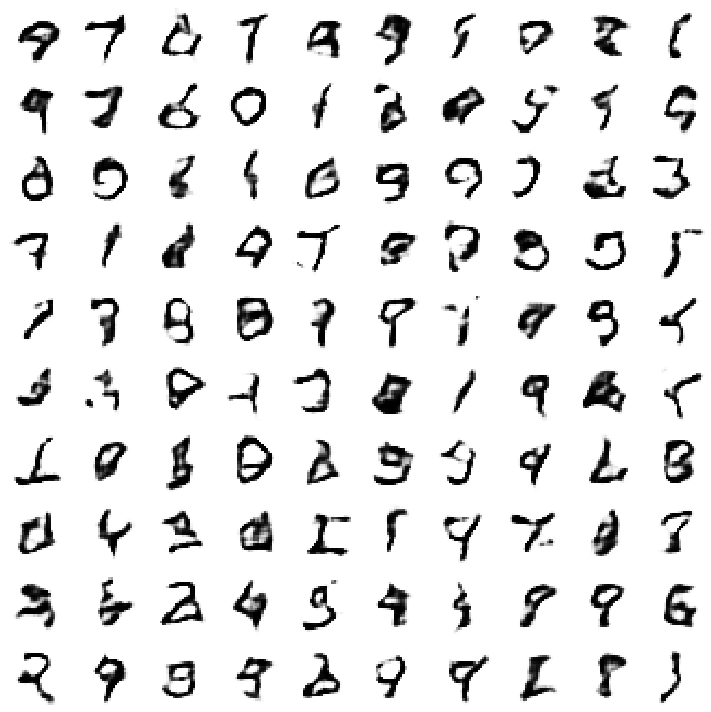

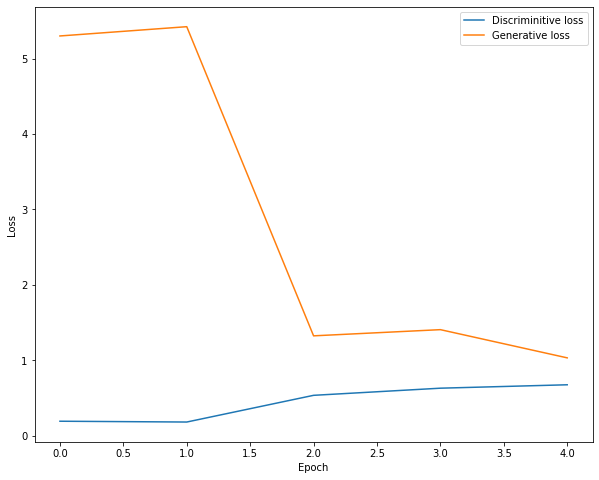

In [56]:
epochs = 15
batchSize = 128
batchCount = X_train.shape[0] / batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == epochs:
        plotGeneratedImages(e)
        
        # Plot losses from every epoch
        plotLoss(e)
        #saveModels(e)



### Try to train the GAN on more number of epochs or optimize the generative/discriminative models to get better results

### Essayez de former le GAN sur un plus grand nombre d'époques ou optimisez les modèles génératif/discriminatif pour obtenir de meilleurs résultats